Użyte biblioteki do zdania "Front Collision Approach".

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import math
import cv2
import numpy as np

Klasa Point - reprezentująca punkt na płaszczyźnie, zdefiniowana przez współrzędne (x, y).

In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

Funkcja służąca do wczytania zdjęcia, przekształcająca go na format RGB.

In [3]:
def load_image(file_path):
    image = cv2.imread(file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Funckja do wizualizacji  obrazu:


*   "num_points" -> kontroluje gęstość punktów,
*   "k" -> parametr do kontrolowania minimalnego odstępu między punktami
* Podział obrazu na punkty, aby można było łatwiej zobaczyć efekty działania algorytmu



In [4]:
def visualize_image(image, num_points=10, k=10):
    num_points*=10
    # Utworzenie wykresu
    plt.figure()

    # Wyświetlenie wczytaniej figurę
    plt.imshow(image)
    plt.title('Loaded figure')
    plt.axis('off')

    # Pobranie wymiaru obrazka
    height, width, _ = image.shape

    # Obliczenie odstępu między punktami na czarnej krawędzi
    step = max(height, width) / num_points

    # Określenie minimalnego odstępu między punktami jako funkcję liniową od liczby punktów
    min_distance = step * (num_points / k)

    #Punkty na czarnym kolorze z rzadszymi odstępami
    black_points = []

    for y in range(0, height, int(step)):
        for x in range(0, width, int(step)):
            if np.all(image[y, x] == [0, 0, 0]):

                # Sprawdzenie, czy punkt jest wystarczająco oddalony od poprzednich punktów
                is_far_enough = True
                for prev_point in black_points:
                    if np.linalg.norm(np.array((prev_point.x, prev_point.y)) - np.array((x, y))) < min_distance:
                        is_far_enough = False
                        break
                if is_far_enough:
                    black_points.append(Point(x, y))

    # Pokazanie punktów na obrazie
    for point in black_points:
        plt.plot(point.x, point.y, 'o', color='#99004C')

    plt.show()
    return black_points

Funkcja tworząca przednią granicę:


*   Tworzy przednią granicę trójkątów na podstawie granicy wypukłej i obrazu.
*   Wylicza trzeci punkt trójkąta, który ma skierowany bok równoległy do krawędzi granicy wypukłej.



In [5]:
def generate_front_points(convex_hull_points, image):
    front_points = []  # Inicjalizacja pustej listy punktów przednich
    num_points = len(convex_hull_points)

    for i in range(num_points):
        # Pobranie dwóch kolejnych punktów z otoczki wypukłej
        point1 = convex_hull_points[i]
        point2 = convex_hull_points[(i + 1) % num_points]

        # Obliczenie współrzędnych trzeciego punktu dla trójkąta równobocznego
        dx, dy = point2.x - point1.x, point2.y - point1.y
        # Obrót o 60 stopni przeciwnie do ruchu wskazówek zegara
        angle = math.atan2(dy, dx) - math.pi / 3
        side_length = math.sqrt(dx**2 + dy**2)

        point3_x = round(point1.x + side_length * math.cos(angle))
        point3_y = round(point1.y + side_length * math.sin(angle))
        point3 = Point(point3_x, point3_y)

        # Sprawdźzenie, czy trzeci punkt znajduje się wewnątrz otoczki i nie jest czarnym pikselem
        if is_inside_convex_hull(point3, convex_hull_points) and not is_black_pixel(point3, image):
            front_points.append(point3)
        else:
            # Odwrócenie trzeciego punkt względem odcinka
            point3_reflected = reflect_point(point3, point1, point2)
            # Ponownie sprawdzenie, czy odzwierciedlony punkt jest poprawny
            if is_inside_convex_hull(point3_reflected, convex_hull_points) and not is_black_pixel(point3_reflected, image):
                front_points.append(point3_reflected)

    return front_points

Funkcja obliczająca kąt polarnej miary dwóch punktów.

In [6]:
def polar_angle(p0, p1):
        return np.arctan2(p1.y - p0.y, p1.x - p0.x)

Funkcja, która oblicza odległość między dwoma punktami.

In [7]:
def dist(p0, p1):
        return np.linalg.norm(np.array([p1.x, p1.y]) - np.array([p0.x, p0.y]))

Funkcja sortująca punkty wokół danego punktu.

In [8]:
def sort_points_by_polar_angle(points, anchor):
        return sorted(points, key=lambda x: (polar_angle(anchor, x), dist(anchor, x)))

Funkcja określająca orientację trzech punktów.


*   0 -> Punkty wspoliniowe
*   1 -> Punkty tworza skret w lewo
*   2 -> Punkty nie tworza skretu w lewo



In [9]:
def orientation(p0, p1, p2):
        val = (p1.y - p0.y) * (p2.x - p1.x) - (p1.x - p0.x) * (p2.y - p1.y)
        if val == 0:
            return 0
        elif val > 0:
            return 1
        else:
            return 2

Implementacja algorytmu Grahama do wyznaczania otoczki wypukłej dla punktów.

In [10]:
def graham(points):
    if len(points) < 3:
        return points

    #Znalezienie punktu o najniższych współrzędnych y, a w przypadku równych y - najniższych x
    lowest_point = min(points, key=lambda p: (p.y, p.x))
    #Sortowanie wedlug najmniejszego kąta
    sorted_points = sort_points_by_polar_angle(points, lowest_point)
    convex_hull = [lowest_point, sorted_points[0], sorted_points[1]]

    # Szukanie trzech punktow tworzacych skret w lewo
    for point in sorted_points[2:]:
        while len(convex_hull) > 1 and orientation(convex_hull[-2], convex_hull[-1], point) != 2:
            convex_hull.pop()
        convex_hull.append(point)

    if convex_hull[-1] != lowest_point:
        convex_hull.append(lowest_point)

    return convex_hull

Funkcja wyświetlająca obraz, otoczkę wypukłą oraz przednią granicę.

In [11]:
def display_front_and_image(front_points, convex_hull, image):
    # Wyświetlenie obrazu
    plt.imshow(image)

    # Wyświetlenie punktu otoczki
    x_hull = [point.x for point in convex_hull]
    y_hull = [point.y for point in convex_hull]
    plt.scatter(x_hull, y_hull, color='orange')

    # Wyświetlenie punktu frontu
    x_front = [point.x for point in front_points]
    y_front = [point.y for point in front_points]
    plt.scatter(x_front, y_front, color='purple')

    # Połączenie punktów otoczki i frontu w trójkąty
    min_len = min(len(convex_hull), len(front_points))
    for i in range(min_len):
        p1 = convex_hull[i+1]
        p2 = convex_hull[(i + 2) % len(convex_hull)]
        p3 = front_points[i]
        triangle = Polygon([(p1.x, p1.y), (p2.x, p2.y), (p3.x, p3.y)], closed=True, fill=None, edgecolor='green')
        plt.gca().add_patch(triangle)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('axis x')
    plt.ylabel('axis y')
    plt.title('convex hull, front points and image')
    plt.show()


Funkcja sprawdzająca, czy punkt leży wewnątrz otoczki wypukłej.

In [12]:
def is_inside_convex_hull(point, convex_hull):
    # Użycie algorytmu "Ray casting" do sprawdzenia, czy punkt leży wewnątrz otoczki wypukłej
    n = len(convex_hull)
    inside = False
    p1 = convex_hull[0]

    for i in range(n + 1):
      # Ustawianie punktu p2 jako kolejny punkt z otoczki wypukłej
        p2 = convex_hull[i % n]
        # Sprawdzenie, czy punkt jest nad dolnym limitem y odcinka p1-p2
        if point.y > min(p1.y, p2.y):
          # Sprawdzenie, czy punkt jest poniżej górnego limity y odcinka p1-p2
            if point.y <= max(p1.y, p2.y):
               # Sprawdzenie, czy punkt jest po lewej stronie odcinka p1-p2
                if point.x <= max(p1.x, p2.x):
                  # Obliczanie punktu przecięcia x
                    if p1.y != p2.y:
                        xinters = (point.y - p1.y) * (p2.x - p1.x) / (p2.y - p1.y) + p1.x
                        # Jeśli p1.x jest równy p2.x lub punkt jest po lewej stronie
                        if p1.x == p2.x or point.x <= xinters:
                            inside = not inside
        p1 = p2
    return inside

Funkcja sprawdzająca, czy piksel obrazu jest czarny.

In [13]:
def is_black_pixel(point, image):
    return (image[point.y, point.x] == [0, 0, 0]).all()

Funkcja odbijająca punkt względem odcinka p1-p2.


*   p1 -> Pierwszy punkt odcinka.
*   p2 -> Drugi punkt odcinka.



In [14]:
def reflect_point(point, p1, p2):
    # Obliczanie różnicy współrzędnych
    dx = p2.x - p1.x
    dy = p2.y - p1.y

    # Obliczanie kwadratu odległości
    dist_sq = dx**2 + dy**2
    # Sprawdzenie, czy punkty p1 i p2 są identyczne
    if dist_sq == 0:
        return point  # Jeśli punkty p1 i p2 są identyczne, zwróć niezmieniony punkt
    # Obliczanie u
    u = ((point.x - p1.x) * dx + (point.y - p1.y) * dy) / dist_sq

    # Obliczanie współrzędnych odbitego punktu
    x = p1.x + u * dx
    y = p1.y + u * dy

    return Point(round(2 * x - point.x), round(2 * y - point.y))

Funkcja zapisująca siatkę trójkątów do pliku jpg.

In [15]:
def save_triangle_mesh_to_file(front_points, convex_hull, file_path):
    plt.figure()  # Tworzenie nowej figury
    plt.gca().invert_yaxis() # Odwracanie osi Y (wizualizacja odwrócona)

    # Dla każdego punktu otoczki wypukłej
    for i in range(len(convex_hull)):
        p1 = convex_hull[i+1]
        p2 = convex_hull[(i + 2) % len(convex_hull)]
        p3 = front_points[i]

        # Tworzenie trójkąta
        triangle = Polygon([(p1.x, p1.y), (p2.x, p2.y), (p3.x, p3.y)], closed=True, fill=None, edgecolor='green')
        # Dodawanie trójkąta do bieżącej osi
        plt.gca().add_patch(triangle)

    # Ustawianie proporcji osi na równą
    plt.gca().set_aspect('equal', adjustable='box')
    # Wyłączanie osi
    plt.axis('off')

    # Zapisywanie pliku
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0, dpi=300, format='jpg')
    # Zamknięcie figury, aby zwolnić pamięć
    plt.close()

Program główny - main.

Rysunek 1.


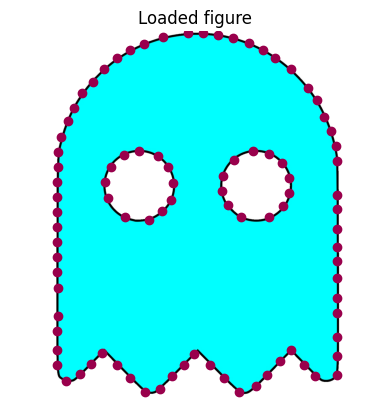

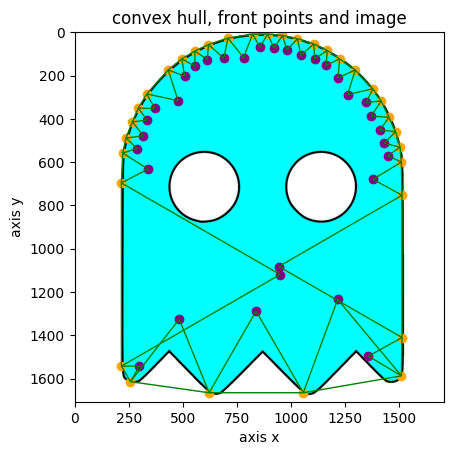


Rysunek 2.


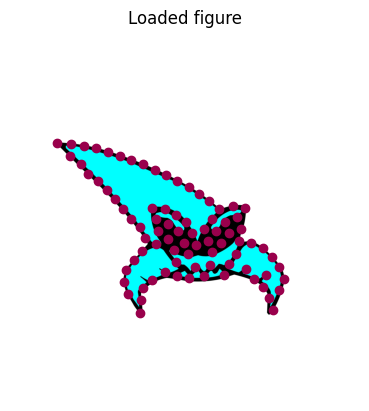

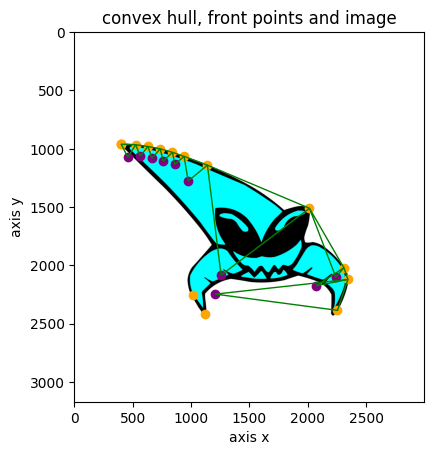


Rysunek 3.


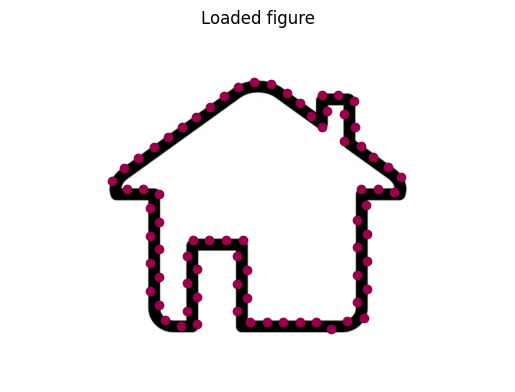

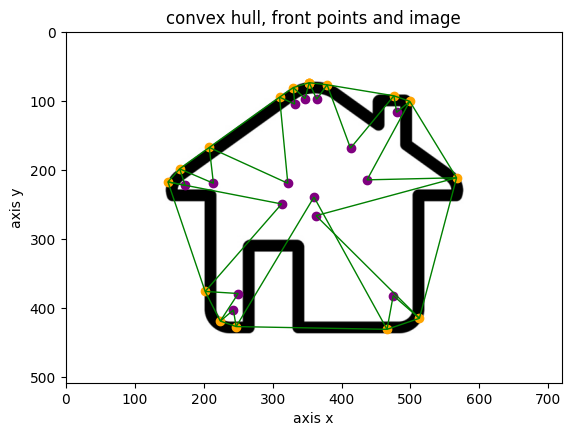

In [23]:
def main():
    image = load_image("pacman_duch.jpg")

    print("Rysunek 1.")
    # Określenie liczby punktów i gęstości
    num_points = 55
    density = 25
    # Wizualizacja obrazu
    black_points = visualize_image(image, num_points, density)
    print("\n")
    # Wyznaczanie otoczki wypukłej dla punktów
    ch = graham(black_points)
    # Tworzenie przedniej granicy
    front = generate_front_points(ch, image)
    # Wyświetlanie obrazu, otoczki wypukłej oraz przedniej granicy
    display_front_and_image(front, ch, image)

    print("\nRysunek 2.")
    num_points = 55
    density = 30
    image2 = load_image("trudny_wariant.jpg")
    black_points = visualize_image(image2, num_points, density)
    print("\n")
    ch = graham(black_points)
    front = generate_front_points(ch, image2)
    display_front_and_image(front, ch, image2)

    print("\nRysunek 3.")
    num_points = 50
    density = 30
    image2 = load_image("dom.jpg")
    black_points = visualize_image(image2, num_points, density)
    print("\n")
    ch = graham(black_points)
    front = generate_front_points(ch, image2)
    display_front_and_image(front, ch, image2)

    # save_triangle_mesh_to_file(front, ch, "mesh.jpg")

if __name__ == "__main__":
    main()